In [576]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

# for reproducibility
torch.manual_seed(1)

In [577]:
image_size = 28

dataset = datasets.ImageFolder(root='../',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [578]:
batch_size = 128




dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [579]:
ngpu = 1
device = 'cuda'

In [580]:
imgs = next(iter(dataloader))


In [581]:
imgs[0].shape

torch.Size([128, 1, 28, 28])

In [582]:
torch.cuda.current_device()
import numpy as np

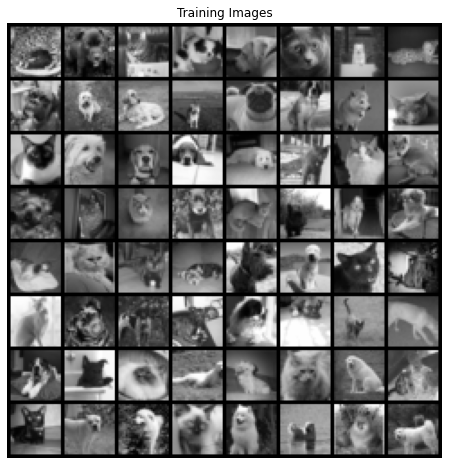

In [583]:
import torchvision.utils as vutils
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [584]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, noise_dim, img_dim):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(noise_dim, hidden_dim)
        self.map2 = nn.Linear(hidden_dim, hidden_dim*4)
        self.map3 = nn.Linear(hidden_dim*4, hidden_dim*8)
        self.map4 = nn.Linear(hidden_dim*8, img_dim)
        self.map5 = nn.Sigmoid()
        
        
    def forward(self, noise):
        x = self.map1(noise)
        x = self.map2(x)
        x = self.map3(x)
        x = self.map4(x)
        x = self.map5(x)
        
        return x
        
    

In [585]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, hidden_dim, slope):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            nn.Linear(img_dim, hidden_dim*16),
            nn.BatchNorm1d(hidden_dim*16),
            nn.LeakyReLU(slope),
            
            nn.Linear(hidden_dim*16, hidden_dim*8),
            nn.BatchNorm1d(hidden_dim*8),
            nn.LeakyReLU(slope),
            
            nn.Linear(hidden_dim*8, hidden_dim*4),
            nn.BatchNorm1d(hidden_dim*4),
            nn.LeakyReLU(slope),
            
            nn.Linear(hidden_dim*4, 1),
        )
    def forward(self, image):
        return self.disc(image)

In [586]:
def get_noise(n_samples, noise_dim, device=device):
    noise = torch.randn(n_samples, noise_dim, device=device)
    return noise

In [587]:
noise_dim = (128, 100)

In [592]:


# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001



In [593]:
gen

Generator(
  (map1): Linear(in_features=10, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=512, bias=True)
  (map3): Linear(in_features=512, out_features=1024, bias=True)
  (map4): Linear(in_features=1024, out_features=784, bias=True)
  (map5): Sigmoid()
)

In [594]:
disc

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=512, out_features=1, bias=True)
  )
)

gen = Generator(hidden_dim = 128, noise_dim = z_dim, img_dim = 784).to(device=device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator(img_dim = image_size, hidden_dim = 128, slope = 0.2).to(device=device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [595]:
channel = 1
gen = Generator(hidden_dim=128, noise_dim=10, img_dim=image_size*image_size*channel).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(img_dim=image_size*image_size*channel, hidden_dim=128, slope=0.2).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [596]:
image_size

28

In [597]:
## DEFINING DISCRIMINATOR AND GENERATOR LOSS

In [598]:
def get_disc_loss(gen, disc, criterion, real_images, num_images, z_dim, device):
    '''
    gen = generator
    disc = discriminator
    criterion = loss function
    real_images = batch of real images
    num_images = number of image the generator is supposed to generate
    z_dim = noise dimension
    device = cuda or cpu
    '''
    noise_vecs = get_noise(num_images, z_dim, device = device)
    fake_images = gen(noise_vecs)
    
    real_pred = disc(real_images)
    fake_pred = disc(fake_images.detach())
    
    loss_real = criterion(real_pred, torch.ones_like(real_pred))
    loss_fake = criterion(fake_pred, torch.zeros_like(fake_pred))
    
    disc_loss = (loss_real + loss_fake) /2
    return disc_loss

In [599]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    gen = generator
    disc = discriminator
    criterion = loss function
    real_images = batch of real images
    num_images = number of image the generator is supposed to generate
    z_dim = noise dimension
    device = cuda or cpu
    '''
    noise_vecs = get_noise(num_images, z_dim, device=device)
    fake_images = gen(noise_vecs)
    
    fake_pred = disc(fake_images)
    gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
    
    return gen_loss
    
    
    

In [600]:


import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [601]:

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''

    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


import torchvision
batch_size = 64
dataloader = torch.utils.data.DataLoader( torchvision.datasets.MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)



EPOCH ====== 0 =======


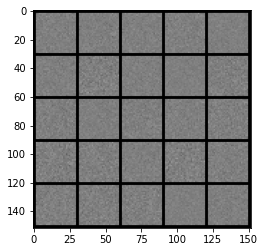

EPOCH ====== 1 =======


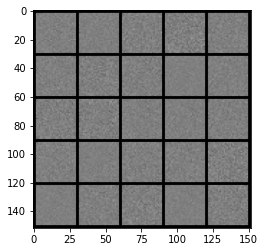

EPOCH ====== 2 =======


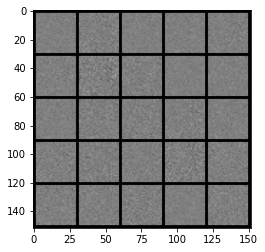

EPOCH ====== 3 =======


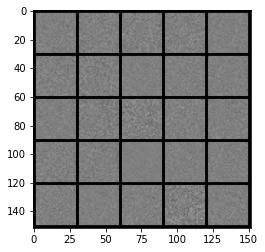

EPOCH ====== 4 =======


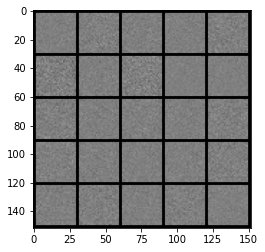

EPOCH ====== 5 =======


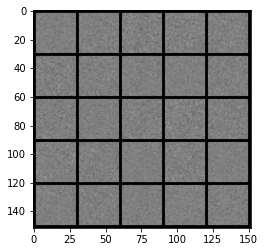

EPOCH ====== 6 =======


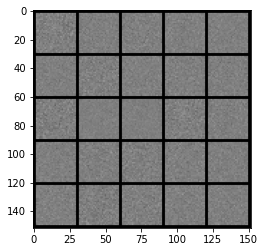

EPOCH ====== 7 =======


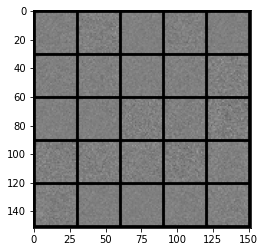

EPOCH ====== 8 =======


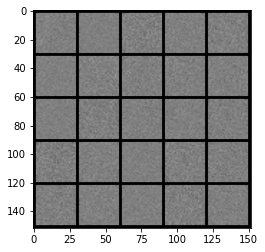

EPOCH ====== 9 =======


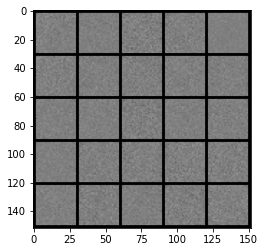

EPOCH ====== 10 =======


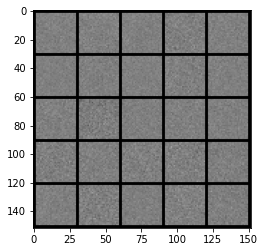

EPOCH ====== 11 =======


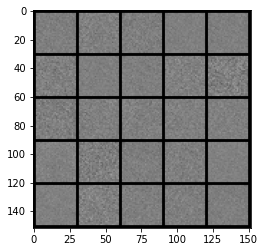

EPOCH ====== 12 =======


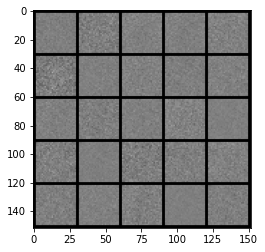

EPOCH ====== 13 =======


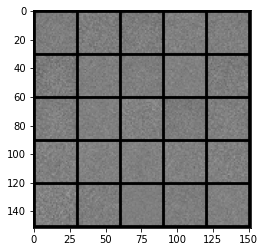

EPOCH ====== 14 =======


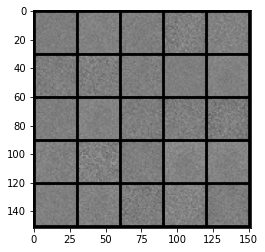

EPOCH ====== 15 =======


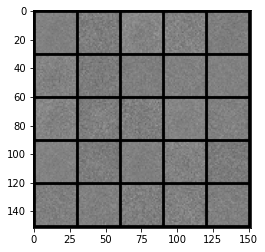

EPOCH ====== 16 =======


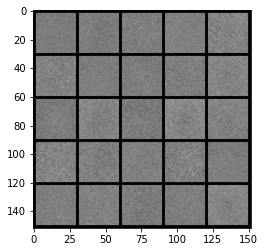

EPOCH ====== 17 =======


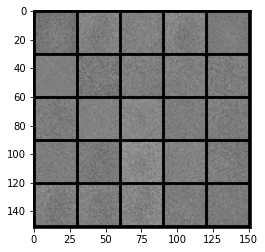

EPOCH ====== 18 =======


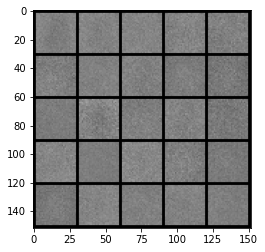

EPOCH ====== 19 =======


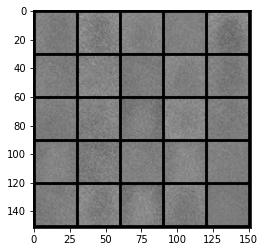

EPOCH ====== 20 =======


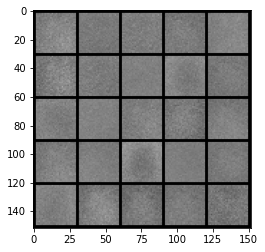

EPOCH ====== 21 =======


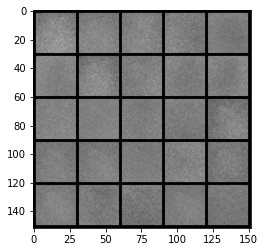

EPOCH ====== 22 =======


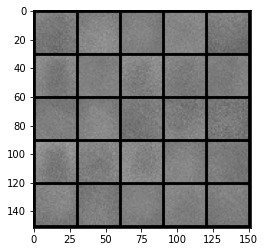

EPOCH ====== 23 =======


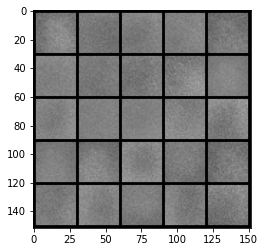

EPOCH ====== 24 =======


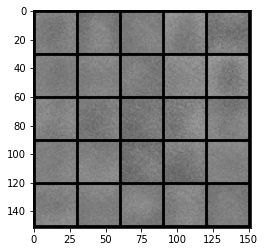

EPOCH ====== 25 =======


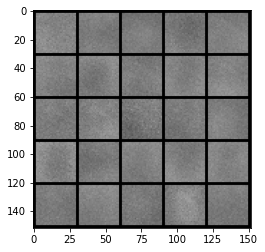

EPOCH ====== 26 =======


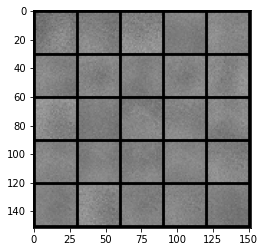

EPOCH ====== 27 =======


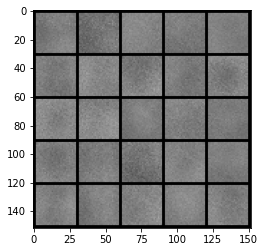

EPOCH ====== 28 =======


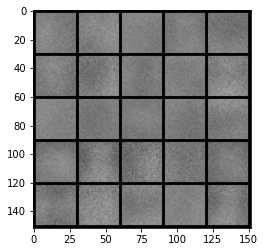

EPOCH ====== 29 =======


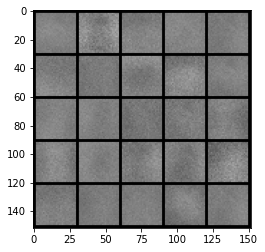

EPOCH ====== 30 =======


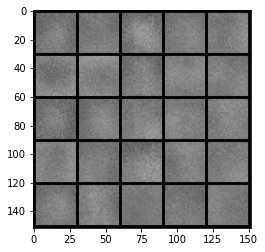

EPOCH ====== 31 =======


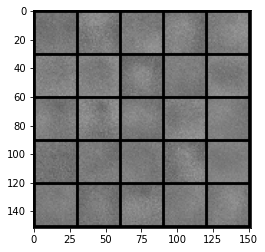

EPOCH ====== 32 =======


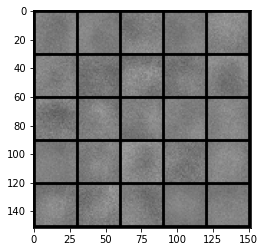

EPOCH ====== 33 =======


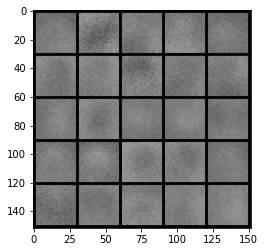

EPOCH ====== 34 =======


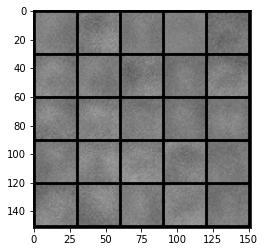

EPOCH ====== 35 =======


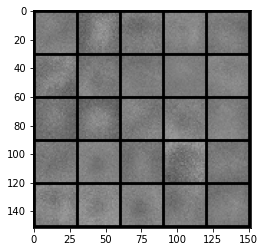

EPOCH ====== 36 =======


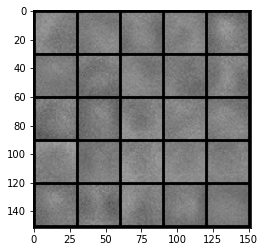

EPOCH ====== 37 =======


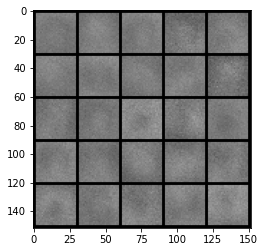

EPOCH ====== 38 =======


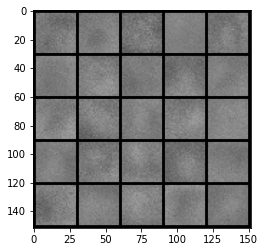

EPOCH ====== 39 =======


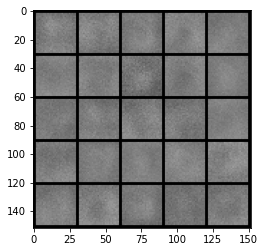

EPOCH ====== 40 =======


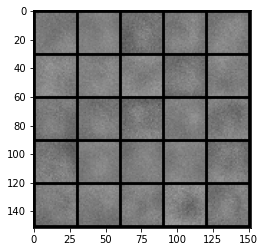

EPOCH ====== 41 =======


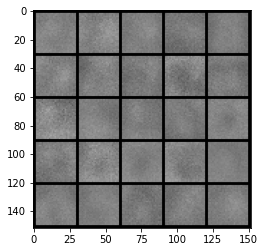

EPOCH ====== 42 =======


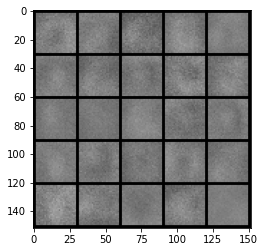

EPOCH ====== 43 =======


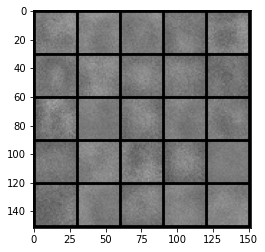

EPOCH ====== 44 =======


In [ ]:
from tqdm.auto import tqdm
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
n_epochs = 1000
z_dim = 10
batch_size = 64


for epoch in range(n_epochs):
    print("EPOCH ======",epoch,"=======")
    
    for real,_ in tqdm(dataloader):
        
        curr_batch_size = len(real)
        
        # Flattening the batch 
        real = real.view(curr_batch_size, -1).to(device)
        #print(real.shape)
        
        ##### UPDATE DISCRIMINATOR ######
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, curr_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        #### UPDATE GENERATOR ######
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, curr_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
    if(1):#epoch %  == 0):
        
        fake_noise = get_noise(curr_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        show_tensor_images(fake,size=(1,image_size,image_size))
        
    

In [ ]:
def gen_block(input_dim, output_dim):
    '''This function will give a combined layer consisting of 
    1) Linear layer.
    2) Batch Regularization
    3) Relu'''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [ ]:
class Generator:
    '''This block defines the generator, which uses the gen_block function to declare layers'''
    def __init__(self, img_dim, hidden_dim, z_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            gen_block(z_dim, hidden_dim),
            gen_block(hidden_dim, hidden_dim*4),
            gen_block(hidden_dim*4, hidden_dim*8),
            gen_block(hidden_dim*8, hidden_dim*16),
            gen_block(hidden_dim*16, img_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return gen(noise)

In [ ]:
def disc_block(input_dim, output_dim, slope):
    '''This function will give a combined layer consisting of
    1) Linear layer
    2) Leaky Relu'''
    
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(slope),
    )

In [ ]:
class Discriminator:
    '''This block defines the discriminator, which uses the disc_block function to declare layers'''
    def __init__(self, img_dim, hidden_dim, z_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            disc_block(img_dim, hidden_dim*16),
            disc_block()
        )